In [28]:
# Import necessary libraries
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Set the filename
filename = "Hourly Electrical Energy_01-01-2022_30-11-2022 - Hourly Electrical Energy_01-01-2022_30-11-2022.csv"


In [30]:
# Read metadata from the file
with open(filename, encoding='utf-8-sig') as f:
    from_line=f.readline().strip().split(',')
    to_line = f.readline().strip().split(',')
    location_line = f.readline().strip().split(',')

# Extract location and date information from the metadata
location = location_line[1]
start_date = from_line[3]
end_date = to_line[3]

In [31]:
print(start_date)
print(end_date)


01/01/2022
30/11/2022


In [32]:
# Read energy consumption data, excluding metadata
energy_data = pd.read_csv(filename, skiprows=15, delimiter=",", thousands='.', decimal=',', encoding='utf-8-sig', usecols=[0, 1, 2], names=['Date', 'Hour', location])

# Convert 'Date' column to datetime type
energy_data['Date'] = pd.to_datetime(energy_data['Date'], format='%d/%m/%Y')

# Set the 'Hour' column to a string type
energy_data['Hour'] = energy_data['Hour'].astype(str)



# Combine the 'Date' and 'Hour' columns into a single 'Datetime' column
energy_data['Datetime'] = energy_data['Date'].astype(str) + ' ' + energy_data['Hour']

# Convert 'Datetime' column to datetime type
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'], format='%Y-%m-%d %H:%M:%S')

# Drop the 'Date' and 'Hour' columns
energy_data.drop(columns=['Date', 'Hour'], inplace=True)

energy_data = energy_data.reindex(columns=['Datetime', location])



In [33]:
energy_data.head(5)

,Datetime,Universitat Aut˜noma de Barcelona
0,2022-01-01 00:00:00,5.35
1,2022-01-01 01:00:00,4.64
2,2022-01-01 02:00:00,4.87
3,2022-01-01 03:00:00,5.43
4,2022-01-01 04:00:00,4.81


In [34]:
API_KEY = "PLFADGXVZDDAC3HLFSCDX46EE"
LATITUDE = "41.3861"
LONGITUDE = "2.1699"

def getWeatherForecast(start_date, end_date):
    # Create an empty DataFrame to store the weather data
    weather_data = pd.DataFrame()

    # Split the query by month
    start_month = int(start_date.split("-")[1])
    end_month = int(end_date.split("-")[1])
    for month in range(start_month, end_month+1):
        # Construct the URL for the API request for this month
        month_str = str(month).zfill(2)
        url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{LATITUDE},{LONGITUDE}/2022-{month_str}-01/2022-{month_str}-31?key={API_KEY}&unitGroup=metric"

        # Send the API request and get the JSON response
        response = requests.get(url)
        data = response.json()

        # Convert the response to a DataFrame and append it to the weather_data DataFrame
        hourly_data = pd.DataFrame(data["days"][0]["hours"])
        hourly_data["Datetime"] = pd.to_datetime(hourly_data["datetime"])
        hourly_data.drop(columns=["datetime"], inplace=True)
        weather_data = pd.concat([weather_data, hourly_data], ignore_index=True)

    return weather_data


In [35]:
# convert start_date and end_date to datetime objects
start_date_obj = datetime.strptime(start_date, '%d/%m/%Y')
end_date_obj = datetime.strptime(end_date, '%d/%m/%Y')

# format start_date and end_date in the desired format
start_date_str = start_date_obj.strftime('%Y-%m-%d')
end_date_str = end_date_obj.strftime('%Y-%m-%d')

print(start_date_str)
print(end_date_str)

2022-01-01
2022-11-30


In [36]:
#I will hardcode this for now, as the api calls are limited per day.
#However, one can simply use getWeatherForecast('start_date_str', 'end_date_str') if the API permits it.

weather_data = getWeatherForecast('2022-01-01', '2022-02-01')

JSONDecodeError: ignored

In [53]:
#some tricks to merge the weather data and energy consumption by datetime
weather_data["Datetime"] = pd.to_datetime(weather_data["datetimeEpoch"], unit="s")
merged_data = pd.merge(energy_data, weather_data, on="Datetime")


In [54]:
weather_data.columns

Index(['datetimeEpoch', 'temp', 'feelslike', 'humidity', 'dew', 'precip',
       'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust',
       'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
       'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon',
       'stations', 'source', 'Datetime', 'severerisk', 'Day'],
      dtype='object')

In [63]:
new_data = merged_data[['Universitat Aut˜noma de Barcelona', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex']]


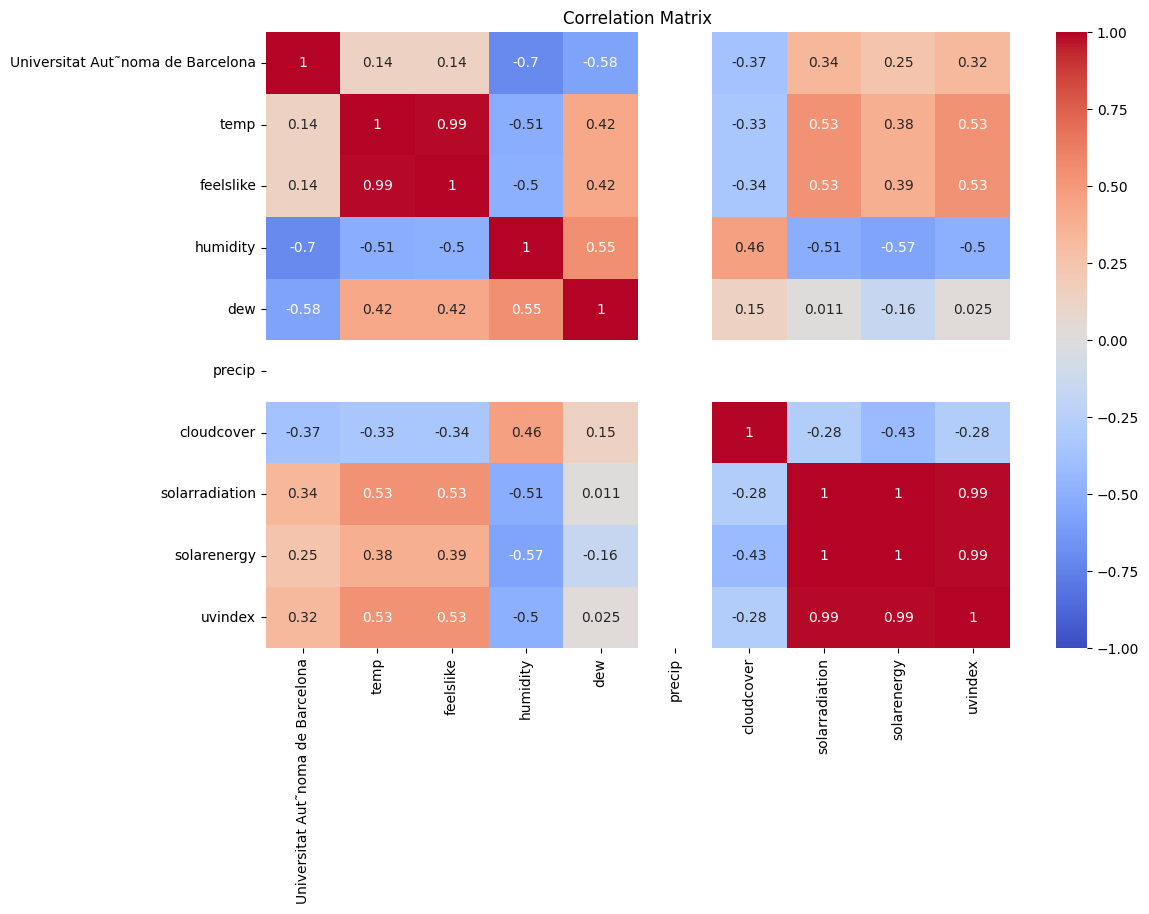

In [64]:
# Calculate the correlation matrix
corr_matrix = new_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [66]:
# Get the correlations with respect to energy consumption
energy_corr = corr_matrix['Universitat Aut˜noma de Barcelona'].sort_values(ascending=False)

# Print the correlations in descending order
print(energy_corr)


Universitat Aut˜noma de Barcelona    1.000000
solarradiation                       0.338541
uvindex                              0.324293
solarenergy                          0.253551
temp                                 0.142137
feelslike                            0.138260
cloudcover                          -0.370737
dew                                 -0.576341
humidity                            -0.703969
precip                                    NaN
Name: Universitat Aut˜noma de Barcelona, dtype: float64
